In [1]:
import numpy, sys, os, pandas as pd
from random import randint
from pickle import dump, load


In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    tokens = text.split()
    print(tokens[:100])
    print('Total Tokens: %d' % len(tokens))
    print('Unique Tokens: %d' % len(set(tokens)))
    return tokens


In [3]:
# organize into sequences of tokens
#the plus one is because the last val in the list will be the expected prediction. 
#Its our Y-train
def sequencesCreate(length, tokens):
    from keras.preprocessing.text import Tokenizer
    sequences = list()
    for i in range(length, len(tokens)):
        # select sequence of tokens
        seq = tokens[i-length:i]
        # convert into a line
        #line = ' '.join(seq)
        # store
        sequences.append(seq)
    print('Total Sequences: %d' % len(sequences))
    print(f'sequences[0][0]: {sequences[0][0]}')
    
    tokenizer = Tokenizer()
    # integer encode sequences of words
    #sequences = [str(i) for i in sequences]
    # print(f'tokenizer: {tokenizer}')
    tokenizer.fit_on_texts(sequences)
    # print(f'tokenizer: {tokenizer}')
    sequences = tokenizer.texts_to_sequences(sequences)
    # print(f'sequences: {sequences}')
    
    return sequences, tokenizer


In [4]:
def modelFit(model, modelName, X, y, seq_length, batch_size, epochs, results_path):
    from keras.callbacks import ModelCheckpoint
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # define the checkpoint
    filepath=f"{results_path.rstrip('/').lstrip('/')}/wi_{{epoch:02d}}_{{loss:.4f}}_{modelName}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    # fit model
    history_callback = model.fit(X, y, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)
    return history_callback


In [12]:
#--- --- ---- --- ---- --- ---- ---- --- ----- ---- ---
# -- Write Files ---- ---- ---- --- ---- --- --- --- -- 
#--- --- ---- --- ---- --- ---- ---- --- ----- ---- ---
def writeFiles(modelName, modelList, seq_length, total_sequences, epochs, batch_size, results_path):
    model_info = {} #history_callback.history
    model_info['seq_length'] = seq_length
    model_info['total_sequences'] = total_sequences
    model_info['batch_size'] = batch_size
    model_info['epochs'] = epochs
    
    # save losses
    rFile = results_path.rstrip('/').lstrip('/') + '/info_' + modelName + '.txt'
    print(f'Info File: {rFile}')
    with open(rFile,'w+') as f:
        f.write(str(modelList))
        f.write('\n')
        f.write(str(model_info))


In [6]:
# define model
def defineModel(vocab_size, seq_length, modelList, length, input_shape):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout
    from keras.layers import LSTM
    from keras.utils import np_utils
    from keras.layers import Embedding, Flatten
    model = Sequential()
    #-- EMBEDDED LAYER --- --- --- ---- --
    #input_dim: size of the vocabulary in the text data.
    #output_dim: size of the vector space where words will be embedded. or size of the output vectors from this layer try 32 or 100 or larger
    #input_length: length of input seq's. ex: if input documents are comprised of 1000 words, it would be 1000.
#     modelList = [{'model':'Embedding', 'input_dim':vocab_size, 'output_dim': 100, 'input_length': seq_length},
#                  {'model': 'LSTM', 'units':256, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': .2}, 
#                  {'model': 'Dense','units':64,'activation':'relu'}, 
#                  {'model': 'LSTM', 'units':256, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': .2}, 
#                  {'model': 'Dense','units':64,'activation':'relu'}, 
#                  {'model':'Flatten'},
#                  {'model': 'Dense','units':vocab_size,'activation':'softmax'},
#                 ]
    for i,layer in enumerate(modelList):
        if layer['model'] == 'Embedding': 
            model.add(Embedding(input_dim=layer['input_dim'], output_dim=layer['output_dim'], 
                                input_length=layer['input_length']))

            print(f"model.add(Embedding(input_dim= {layer['input_dim']}, output_dim={ layer['output_dim'] }, input_length={ layer['input_length'] }))")
        elif layer['model'] == 'LSTM':
            #model.add(LSTM(100, return_sequences=True))
            #model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_dim=1))
            model.add(LSTM(units=layer['units'], use_bias=layer['use_bias'], 
                           dropout=layer['dropout'], recurrent_dropout=layer['recurrent_dropout'], 
                           return_sequences = layer['return_sequences']))
            print(f"model.add(LSTM(units={layer['units']}, use_bias={layer['use_bias']}, dropout={layer['dropout']}, recurrent_dropout={layer['recurrent_dropout']} ))")

        elif layer['model'] == 'Dropout':
            #model.add(Dropout(0.2))
            model.add(Dropout(layer['dropout_rate']))
            print(f"model.add(Dropout({layer['dropout_rate']}))")

        elif layer['model'] == 'Dense':
            #{'model': 'Dense','units':64,'activation':relu'}, 
            #model.add(Dense(100, activation='relu'))
            model.add(Dense(units=layer['units'], activation=layer['activation']))
            print(f"model.add(Dense(units={layer['units']}, activation={layer['activation']}))")

        elif layer['model'] == 'Flatten':
            model.add(Flatten())
            print(f'model.add(Flatten())')
        else:
            raise IOError ('invalid layer')
        
    #Create the model name
    import datetime
    now = datetime.datetime.now()
    modelName = now.strftime("%Y-%m-%d_%H-%M")

    try:
        print(model.summary())
    except:
        pass
    return model, modelName


In [13]:
def trainModelComplete(results_path):
    from keras.utils import to_categorical
    
    #--- PARAMETERS --- --- --- ---- --- --- ---- ---- --- ----- --- --- ----
    #notes from website:
    #-- Common values are 50, 100, and 300. We will use 50 here, --
    #-- but consider testing smaller or larger values. --
    #-- We will use a two LSTM hidden layers with 100 memory cells each. --
    #-- More memory cells and a deeper network may achieve better results. --
    drseuss_text = 'data/combinedText.txt'
    seed_length = 50
    length = seed_length + 1
    epochs = 2
    batch_size = 128
    #-- ---- ---- --- ---- ----- ---- ----- ---- ----- ----- ---- ---- ---- ----
    
    #-- load document --- --- --- --- --
    drseuss_text = 'data/combinedText.txt'
    tokens = load_doc(drseuss_text)

    #-- Create sequencer and tokenizer -- --- --- --- --- --- --- --- 
    sequences, tokenizer = sequencesCreate(length, tokens)
    vocab_size = len(tokenizer.word_index) + 1

    #-- Creating X, y -- --- --- --- --- --- --- -- --
    df = pd.DataFrame(sequences)
    print(f'sequences:\n{df.head(5)}')
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
    seq_length = X.shape[1]
    input_shape = X.shape
    #-- One hot encoding -- --- --- --- --- --- -
    y = to_categorical(y, num_classes=vocab_size)
    print(f'seq_length: {seq_length}\nshape of X: {X.shape}\nshape of y: {y.shape}')
    #-- -- ---- --- --- --- --- --- ---- --- --- --- --

    #-- Model List --- --- --- --- --- --- --- --- --- -- ---- --- --- --- ---- -- --
#     modelList = [{'model':'Embedding', 'input_dim':vocab_size, 'output_dim': 256, 'input_length': seq_length},
#                  {'model': 'LSTM', 'units':256, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': 0, 'return_sequences': True}, 
#                  {'model': 'Dense','units':64,'activation':'relu'}, 
#                  {'model': 'LSTM', 'units':256, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': 0, 'return_sequences': True}, 
#                  {'model': 'Dense','units':64,'activation':'relu'}, 
#                  {'model':'Flatten'},
#                  {'model': 'Dense','units':vocab_size,'activation':'softmax'},
#                 ]
    modelList = [{'model':'Embedding', 'input_dim':vocab_size, 'output_dim': 512, 'input_length': seq_length},
                 {'model': 'LSTM', 'units':512, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': 0, 'return_sequences': True}, 
                 {'model': 'Dense','units':100,'activation':'relu'}, 
#                  {'model': 'LSTM', 'units':512, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': 0, 'return_sequences': True}, 
#                  {'model': 'Dense','units':100,'activation':'relu'}, 
                 {'model':'Flatten'},
                 {'model': 'Dense','units':vocab_size,'activation':'softmax'},
                ]

    #-- --- ---- --- ---- --- --- ---- --- ---- --- ---- --- ---- --- --- --- --- ---
    
    print(f'drseuss_text: \'{drseuss_text}\'\nseed_length: {seed_length}\nepochs: {epochs}\nbatch_size: {batch_size}'
     f'\nmodelList: {modelList}')
    
    #-- Create Model -- --- --- --- ---- --- -- ---- --- --- --- --- --- --- ---- --- ---
    model, modelName = defineModel(vocab_size, seq_length, modelList, length, input_shape)
    #-- save the tokenizer --- --- --- ---- --- --- ---- --
    dump(tokenizer, open(results_path.rstrip('/').lstrip('/') + f'/token_'+modelName+'.pkl', 'wb'))
    #-- Save history and final model --- -
    writeFiles(modelName, modelList, seq_length, len(sequences), epochs, batch_size, results_path)
    #-- Fit model -- ---- --- --- --- ---- --- --- ---- --- --- --- --- --- --- --- --- 
    history_callback = modelFit(model, modelName, X, y, seq_length, batch_size, epochs, results_path)
    loss_history = history_callback.history
    with open(results_path.rstrip('/').lstrip('/') + f'/loss_history_{modelName}.txt', 'w+') as f:
        f.write(str(loss_history))

In [8]:
# generate a sequence from a language model
#def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
def generate_seq(seq_length, seed_text, n_words, filepath = '', modelName = '', tokenizerName = '', ):
    from keras.models import load_model
    from keras.preprocessing.sequence import pad_sequences
    import re

    if filepath :
        highest_epoch = 0
        for filename in os.listdir(filepath):
            m = re.search('^wi_(\d+)_', filename)
            if m:
                if int(m.group(1)) > highest_epoch:
                    highest_epoch = int(m.group(1))
                    modelName = filepath+'/'+filename
            if re.search('token', filename):
                tokenizerName = filepath+'/'+filename
        
    # load the model
    model = load_model(modelName)

    # load the tokenizer
    tokenizer = load(open(tokenizerName, 'rb'))
    
    #Make 50 words long
    seed_text = ' '.join(seed_text.split(' ')[0:seq_length])
    
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    
    del model
    return ' '.join(result)

In [9]:
# modelList = [{'model':'Embedding', 'input_dim':2830, 'output_dim': 256, 'input_length': 50},
#                  {'model': 'LSTM', 'units':256, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': 0, 'return_sequences': True}, 
#                  {'model': 'Dense','units':64,'activation':'relu'}, 
#                  {'model': 'LSTM', 'units':256, 'use_bias':True, 'dropout':.2, 'recurrent_dropout': 0, 'return_sequences': True}, 
#                  {'model': 'Dense','units':64,'activation':'relu'}, 
#                  {'model':'Flatten'},
#                  {'model': 'Dense','units':2830,'activation':'softmax'},
#                 ]
# history_callback = {'history':{'loss': [6.8130, 6.3438, 6.0809, 5.6680, 5.0674, 4.1888, 3.2263, 2.4416, 1.8358, 1.3483, 0.9936, 0.7174, 0.5278, 0.3948, 0.2838, 0.2132, 0.1515, 0.1078, 0.0862, 0.0653, 0.0591, 0.0499, 0.0395, 0.0275, 0.0271, 0.0293, 0.0370, 0.0441, 0.0782, 0.1003, 0.0644, 0.0407, 0.0296, 0.0202, 0.0133, 0.0067, 0.0048, 0.0053, 0.0050, 0.0076, 0.0120, 0.0162, 0.0466, 0.1344, 0.1101, 0.0600, 0.0288, 0.0118, 0.0063], 
#                     'acc':  [0.0366, 0.0477, 0.0514, 0.0527, 0.0647, 0.1239, 0.1239, 0.4201, 0.5374, 0.6495, 0.7304, 0.7957, 0.8472, 0.8845, 0.9168, 0.9394, 0.9593, 0.9714, 0.9791, 0.9854, 0.9866, 0.9900, 0.9918, 0.9948, 0.9946, 0.9945, 0.9913, 0.9897, 0.9782, 0.9701, 0.9821, 0.9881, 0.9925, 0.9952, 0.9975, 0.9991, 0.9997, 0.9996, 0.9996, 0.9987, 0.9984, 0.9962, 0.9854, 0.9570, 0.9661, 0.9805, 0.9917, 0.9974, 0.9993]}}
# writeFiles('NULL', '2018-10-22_11-31', history_callback, modelList, 50, total_sequences = 16175)

In [11]:
if __name__ == '__main__':
    trainModelComplete('.')

Using TensorFlow backend.


['yertle', 'the', 'turtle', 'on', 'the', 'far', 'away', 'island', 'of', 'sala', 'ma', 'sond', 'yertle', 'the', 'turtle', 'was', 'king', 'of', 'the', 'pond.', 'a', 'nice', 'little', 'pond.', 'it', 'was', 'clean.', 'it', 'was', 'neat.', 'the', 'water', 'was', 'warm.', 'there', 'was', 'plenty', 'to', 'eat.', 'the', 'turtles', 'had', 'everything', 'turtles', 'might', 'need.', 'and', 'they', 'were', 'all', 'happy.', 'quite', 'happy', 'indeed.', 'they', 'were.', 'untill', 'yertle', 'the', 'king', 'of', 'them', 'all', 'decided', 'the', 'kingdom', 'he', 'ruled', 'was', 'too', 'small.', 'im', 'ruler', 'said', 'yertle', 'of', 'all', 'that', 'i', 'see.', 'but', 'i', 'dont', 'see', 'enough.', 'thats', 'the', 'trouble', 'with', 'me.', 'with', 'this', 'stone', 'for', 'a', 'throne', 'i', 'look', 'down', 'on']
Total Tokens: 16226
Unique Tokens: 2829
Total Sequences: 16175
sequences[0][0]: yertle
sequences:
    0    1    2     3     4     5     6     7     8     9   ...     41    42  \
0  162    1  161

KeyboardInterrupt: 

In [ ]:
#trainModelComplete()

In [ ]:
def json_create(filepath = '.'):
    import os, ast, json, re, seed
    datetime = {}
    #-- Determine JSON file name -- 
    jsonFile = f'{filepath}/Alldata.json'; i = '0'
    while os.path.isfile(jsonFile):
        i = str(int(i)+1)
        jsonFile = f"{filepath}/Alldata{i}.json"
        
    for filename in os.listdir(filepath):
        #wi_01_6.7077__2018-10-22_09-29.hdf5
        m = re.search('wi_(..)_(......)__*(....-..-..)_(..-..).hdf5', filename)
        if m:
            epoch, loss, date, time = m.group(1), m.group(2), m.group(3), m.group(4)
            if date+'_'+time not in datetime.keys():
                #print(f"{date+'_'+time} not in KEYS: \n{datetime.keys()}")
                tokenizer = filepath+f'/token_{date}_{time}.pkl'
                try:
                    with open(filepath.rstrip('/').lstrip('/')+'/info_' + date+'_'+time + '.txt') as f:
                        text = f.read()
                    modelList = text.split(']')[0] + ']'
                    modelHistory = '{' + ']'.join(text.split(']')[1:]).split('{')[1]
                    #print(f"NEW DATA: {date+'_'+time}")
                    modelHistory = ast.literal_eval(modelHistory)
                    modelList = ast.literal_eval(modelList)
                    epochs = modelHistory['epochs']
                    if os.path.isfile(f"{date+'_'+time}_loss_history.txt"):
                        with open(f"{filepath.rstrip('/').lstrip('/')}/{date+'_'+time}_loss_history.txt") as f:
                            model_history = f.read()
                        model_history = ast.literal_eval(model_history)
                        modelHistory['model_history'] = model_history
                except:
                    modelList = []
                    modelHistory = {}
                datetime[date+'_'+time] = {'model_list': modelList,
                                           'model_history': modelHistory,
                                           'sequence_list': ['no_model_data']*(epochs+1)}
                try:
                    seq_length = modelHistory['seq_length']
                except:
                    seq_length = 50
                #print(f'{epoch}: {datetime}')
            #seq_length, seed_text, n_words, filepath = '', modelName = '', tokenizerName = '', )
            datetime[date+'_'+time]['sequence_list'][int(epoch)] = generate_seq(seq_length, seed.seed_text, 50, filepath, filename, tokenizer) 
            print('\n',filename, ": ",datetime[date+'_'+time]['sequence_list'][int(epoch)])
            #-- Write JSON file -- --- ----
            with open(jsonFile, 'w+') as fp:
                json.dump(datetime, fp)

In [ ]:
#wi_76_0.0010__51_LSTM_256_True_Dense_256_relu_Dropout_0.2__LSTM_128_True_Dense_128_relu_Dropout_0.2__LSTM_64_False_Dense_64_relu_Flatten___Dense_2830_softmax.hdf
def jsonify_the_old_style_file(filepath = '.'):
    import seed, re, os, json
    jsonFile = filepath + '/Alldata.json'; i = '0'
    #-- Determine JSON file name -- 
    while os.path.isfile(jsonFile):
        i = str(int(i)+1)
        jsonFile = f"{filepath}/Alldata{i}.json"
    tokenizer = filepath + '/toke_51_LSTM_256_True_Dense_256_relu_Dropout_0.2__LSTM_128_True_Dense_128_relu_Dropout_0.2__LSTM_64_False_Dense_64_relu_Flatten___Dense_2830_softmax.pkl'
    jsondict = {'sequences': ['no_data']*112, 'model':None, 'loss': ['no_data']*112}
    for filename in os.listdir(filepath):
        m = re.search('wi_(..)_(......)__(.*).hdf5', filename)
        if m and re.search('51_LSTM_256_True_Dense_256_relu_Dropout_0.2__LSTM_128_True_Dense_128_relu_Dropout_0.2__LSTM_64_False_Dense_64_relu_Flatten___Dense_2830_softmax', filename):
            epoch, loss, modellist = m.group(1), m.group(2), m.group(3)
            jsondict['model'] = modellist
            jsondict['loss'][int(epoch)] = float(loss)
            #seq_length, seed_text, n_words, filepath = '', modelName = '', tokenizerName = '', )
            jsondict['sequences'][int(epoch)] = generate_seq(50, seed.seed_text, 50, os.path.join(filepath,filename), tokenizer, 50, seed.seed_text, 50)
            print(epoch, ': ', jsondict['sequences'][int(epoch)])
            #-- Write JSON file -- --- ----
            with open(jsonFile, 'w+') as fp:
                json.dump(jsondict, fp)

In [70]:
import pandas as pd
df=pd.read_json('Alldata3.json')
df['loss'] = df['loss'].replace('no_data', 'nan') 
df=df.truncate(before=1, after=48)
df.head()

df2=pd.read_json('Alldata.json')
data2Dict = df2.to_dict()
df2=pd.DataFrame()
df2['loss'] = data2Dict['2018-10-22_11-31']['model_history']['loss']
df2

,loss
0,6.8130
1,6.3438
2,6.0809
3,5.6680
4,5.0674
5,4.1888
6,3.2263
7,2.4416
8,1.8358
9,1.3483


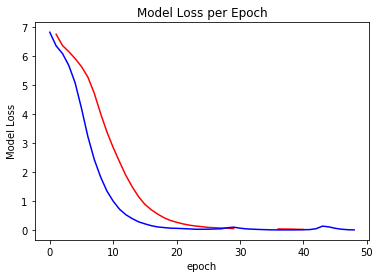

<Figure size 432x288 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

x = df.index
y = df['loss']
names = df['sequences']
#c = np.random.randint(1,5,size=15)

#norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
#sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)
sc = plt.plot(x,y, 'r', df2.index, df2['loss'], 'b')#, cmap=cmap)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)
plt.ylabel('Model Loss')
plt.xlabel('epoch')
plt.title('Model Loss per Epoch')
plt.show()
plt.savefig('ModelLoss.PNG')